## Import Libraries

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import equinox as eqx
import optax
from functools import partial

In [2]:
import numpy as np
import math
from tqdm.auto import tqdm

import sklearn.preprocessing as PP
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score

/local/scratch/a/achakkit/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# import the fun
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from HullParameterization import Hull_Parameterization as HP

np.set_printoptions(suppress=True) # don't use scientific notation


In [4]:
# ! pip install pip install -U scikit-learn
import numpy
from stl import mesh

## Load Data

In [5]:
# Load in the Data:

#Step 1: Load in the data
folder = 'HullParam_MultiObj/'
path = './Restructured_Dataset/'
X = np.load(path + folder +'X_num_train.npy')
#Y = np.load(path + folder+ 'Y_MultiObj.npy')
Y = np.load(path + folder+ 'y_train.npy')

print(np.min(Y,axis=0))

Cons = np.zeros((len(X),1))

Y_stats = np.array([np.mean(Y,axis=0), np.std(Y,axis=0)])


neg_folder = 'NegativeData/'

X_neg = np.load(path + neg_folder +'X_negativeData.npy')
Y_neg = np.load(path + neg_folder +'Y_negativeData.npy')
Cons_neg = np.zeros((len(X_neg),1))+1
 #np.load(neg_path+'Con_SatisfyVec.npy')

X_LIMITS = np.load(path+'X_LIMITS.npy')

X_lower_lim = [X_LIMITS[:,0].tolist()]                   
X_upper_lim = [X_LIMITS[:,1].tolist()]

#X_set = np.concatenate((X,X_neg))

Y_set = [[1],[1]] #np.concatenate((Y,Y_neg))

[-162.75037      -3.3441992    -2.4861941    -0.5535028    -0.6715196
   -0.80750316   -3.834086  ]


## Timestep embedding

In [6]:
def timestep_embedding(timesteps, dim, max_period=10000):
    """
    From https://github.com/rotot0/tab-ddpm
    
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = jnp.exp(
        -math.log(max_period) * jnp.arange(start=0, stop=half) / half) #, dtype=torch.float32
     #.to(device=timesteps.device)
    args = timesteps[:, None]*freqs[None]
    embedding = jnp.concatenate([jnp.cos(args), jnp.sin(args)], axis=-1)
    if dim % 2:
        embedding = jnp.concatenate([embedding, jnp.zeros(embedding[:, :1].shape)], axis=-1)
    return embedding

In [7]:
t = np.random.rand(1)
print(t)
d = 3

timestep_embedding(t,d).shape

[0.2813284]


2024-05-02 10:16:15.575110: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(1, 3)

## MLP DDPM

In [8]:
class Denoise_MLP_Model(eqx.Module):
    fc: list
    xdim: int
    ydim: int
    cdim: int
    tdim: int
    net: list
    X_embed: eqx.Module
    Con_embed: eqx.Module
    time_embed: eqx.Module


    def __init__(self, DDPM_Dict):
        # nn.Module.__init__(self)
        super(Denoise_MLP_Model, self).__init__()
        self.xdim = DDPM_Dict['xdim']
        self.ydim = DDPM_Dict['ydim']
        self.cdim = DDPM_Dict['cdim']
        self.tdim  = DDPM_Dict['tdim']
        self.net = DDPM_Dict['net']
        # self.device = device
        
        self.fc = [] #nn.ModuleList()
        
        self.fc.append(self.LinLayer(self.tdim,self.net[0])) # 128 -> 1024

        key = jax.random.PRNGKey(0)
        
        for i in range(1, len(self.net)):
            self.fc.append(self.LinLayer(self.net[i-1],self.net[i])) # 1024 -> 1024
            
        self.fc.append(self.LinLayer(self.net[-1], self.tdim))  # 1024 -> 128
        
        self.fc.append(eqx.nn.Sequential([eqx.nn.Linear(self.tdim, self.xdim, key = key)])) # 128 -> 44
        
    
        self.X_embed = eqx.nn.Linear(self.xdim, self.tdim, key=key) # 44 -> 128
        
        '''
        self.Y_embed = nn.Sequential(
            nn.Linear(self.ydim, self.tdim),
            nn.SiLU(),
            nn.Linear(self.tdim, self.tdim))
        '''
        self.Con_embed = eqx.nn.Sequential([
                    eqx.nn.Linear(self.cdim, self.tdim, key=key),
                    eqx.nn.Lambda(jax.nn.silu),
                    eqx.nn.Linear(self.tdim, self.tdim, key=key)]) # 
        
        
        self.time_embed = eqx.nn.Sequential([
            eqx.nn.Linear(self.tdim, self.tdim, key=key),
            eqx.nn.Lambda(jax.nn.silu),
            eqx.nn.Linear(self.tdim, self.tdim, key=key)])
         # 128 -> 128
     
        
    def LinLayer(self, dimi, dimo):
        key = jax.random.PRNGKey(0)
        return eqx.nn.Sequential([eqx.nn.Linear(dimi,dimo, key=key),
                             eqx.nn.Lambda(jax.nn.silu),
                             eqx.nn.LayerNorm(dimo),
                             eqx.nn.Dropout(p=0.1, inference=True)]) # Decide on Dropout
    
    @partial(jax.vmap, in_axes=(None, 0))
    def make_time_embed(self, x):
        return self.time_embed(x)
        
    @partial(jax.vmap, in_axes=(None, 0, 0))
    def __call__(self, x, timesteps):
        # print("Call")
        a = self.X_embed(x)
        # print('a.shape',a.shape )

        # print(timestep_embedding(timesteps, self.tdim).reshape(self.tdim,1).shape)
        tem = self.make_time_embed(timestep_embedding(timesteps, self.tdim).reshape(1, self.tdim))
        
        # print('tem.shape',tem.shape )
        
        x = a +  tem.reshape(self.tdim,)
        # print(x.shape)

        for i in range(0, len(self.fc)):
            x = self.fc[i](x)
        return x

    @partial(jax.vmap, in_axes=(None, 0, None))
    def forward(self, x, timesteps):
        # print("Call")
        a = self.X_embed(x)
        # print('a.shape',a.shape )

        # print(timestep_embedding(timesteps, self.tdim).reshape(self.tdim,1).shape)
        tem = self.make_time_embed(timestep_embedding(timesteps, self.tdim).reshape(1, self.tdim))
        
        # print('tem.shape',tem.shape )
        
        x = a +  tem.reshape(self.tdim,)
        # print(x.shape)

        for i in range(0, len(self.fc)):
            x = self.fc[i](x)
        return x

In [9]:
DDPM_Dict = {
        'xdim' : len(X[0]),             # Dimension of parametric design vector
        'datalength': len(X),           # number of samples
        'X_LL' : X_lower_lim,           # lower limits of parametric design vector variables
        'X_UL' : X_upper_lim,
        'ydim': len(Y_set[0]),          # Number of objectives
        'cdim': len(Cons[0]),           # number of classes for classifier
        'gamma' : 0.5,                  # weight of feasibility guidence for guided sampling
        'lambdas': [1,1,1,1,1,1,1],     # dummy variable for performance guided sampling
        'tdim': 128,                    # dimension of latent variable
        'net': [1024,1024,1024,1024],   # network architecture
        'batch_size': 1024,             # batch size
        'Training_Epochs': 100000,      # number of training epochs
        'Diffusion_Timesteps': 1000,    # number of diffusion timesteps
        'lr' : 0.00025,                 # learning rate
        'weight_decay': 0.0,            # weight decay
        'device_name': 'cuda:0'}        # gpu device name

ddpm_mlp = Denoise_MLP_Model(DDPM_Dict)

In [10]:
ddpm_mlp = Denoise_MLP_Model(DDPM_Dict)

x = np.random.rand(120, 44)
# x = np.random.rand(44)
n = 120
n_steps = 200
# t = np.random.choice(n_steps, (n,1))
t = np.random.choice(n_steps, (n))

print(t.shape)

# ddpm_mlp.time_embed(t).shape

# ddpm_mlp.make_time_embed(t).shape

# ddpm_mlp(x, t).shape



# ddpm_mlp.forward(x, np.array([2])).shape

(120,)


In [11]:
class forward_net(eqx.Module):
    n_steps: int

    datalength: int
    batch_size: int
    alphas: jnp.ndarray
    alpha_bars: jnp.ndarray
    betas: jnp.ndarray

    def __init__(self, n_steps=200, min_beta=10 ** -4, max_beta=0.02, datalength = 0, batch_size = 1024):
        super(forward_net, self).__init__()

        self.n_steps = n_steps
        self.betas = jnp.linspace(min_beta, max_beta, n_steps)
        self.alphas = 1 - self.betas
        self.alpha_bars = jnp.array([jnp.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))])

        self.batch_size = batch_size

        self.datalength = datalength

    # @partial(jax.vmap, in_axes=(None, 0, None, None))
    def __call__(self, x0, t, eta=None):
        n = len(t)
        a_bar = self.alpha_bars[t]
        # print('a_bar', a_bar)
        if eta is None:
            eta = np.random.randn(n)
        # print('x0 shape', x0.shape)
        # print('a_bar shape', a_bar.shape)
        # print('eta shape', eta.shape)
        noisy = jnp.sqrt(a_bar).reshape(n,1)*x0 + jnp.sqrt((1 - a_bar)).reshape(n,1)* eta
        # noisy = jnp.sqrt(a_bar).reshape(n,1) * x0 + jnp.sqrt((1 - a_bar)).reshape(n,1) * eta
        return noisy

In [12]:
ddpm_params = forward_net(n_steps=200, min_beta=10 ** -4, max_beta=0.02, datalength=len(X), batch_size = 1024)
x = np.random.rand(128, 44)
# x = np.random.rand(44)
n = 128
n_steps = 200
t = np.random.choice(n_steps, (n,1))
eta = np.random.randn(128, 44)

ddpm_params(x, t, eta).shape

(128, 44)

In [13]:
ddpm_params = forward_net(n_steps=200, min_beta=10 ** -4, max_beta=0.02, datalength=len(X), batch_size = 1024)

### Pre-Process Data

In [14]:
class Data_Normalizer:
    def __init__(self, X_LL_Scaled, X_UL_Scaled,datalength):
        
        self.normalizer = PP.QuantileTransformer(
            output_distribution='normal',
            n_quantiles=max(min(datalength // 30, 1000), 10),
            subsample=int(1e9)
            )
        
        self.X_LL_Scaled = X_LL_Scaled
        self.X_UL_Scaled = X_UL_Scaled
        
        self.X_LL_norm = np.zeros((1,len(X_LL_Scaled)))
        self.X_UL_norm = np.zeros((1,len(X_LL_Scaled)))
        
        self.X_mean = np.zeros((1,len(X_LL_Scaled)))
        self.X_std = np.zeros((1,len(X_LL_Scaled)))
        
    def fit_Data(self,X):
        
        
        
        x = 2.0*(X-self.X_LL_Scaled)/(self.X_UL_Scaled- self.X_LL_Scaled) - 1.0
        
        self.normalizer.fit(x)
        x = self.normalizer.transform(x) # Scale Dataset between 
        #x = (X-self.X_LL_Scaled)/(self.X_UL_Scaled- self.X_LL_Scaled)
        

        return x
    
    def transform_Data(self,X):
        x = 2.0*(X-self.X_LL_Scaled)/(self.X_UL_Scaled- self.X_LL_Scaled) - 1.0
        
        
        x = self.normalizer.transform(x)
        return x
        

    def scale_X(self,z):
        #rescales data
        z = self.normalizer.inverse_transform(z)
        scaled = (z + 1.0) * 0.5 * (self.X_UL_Scaled - self.X_LL_Scaled) + self.X_LL_Scaled
        #scaled = z* (self.X_UL_Scaled - self.X_LL_Scaled) + self.X_LL_Scaled

        '''
        x = self.normalizer.inverse_transform(x)
        
        #scaled = x* (self.X_UL_norm - self.X_LL_norm) + self.X_LL_norm
        '''
        #z = (z + 1.0) * 0.5 * (8.0) + 4.0
       
        #scaled = z*self.X_std + self.X_mean
        #scaled = self.normalizer.inverse_transform(scaled)
        return scaled     

In [17]:
data_norm = Data_Normalizer(np.array(DDPM_Dict['X_LL']),np.array(DDPM_Dict['X_UL']), len(X))

X = data_norm.fit_Data(X)

X_neg = data_norm.transform_Data(X_neg)

### Training Loop

In [19]:
def loss(model, ddpm, x0, t, eta):
    noisy_imgs = ddpm(x0, t, eta)
    # Getting model estimation of noise based on the images and the time-step
    eta_theta = model(noisy_imgs, t)

    # Optimizing the MSE between the noise plugged and the predicted noise
    return optax.l2_loss(eta_theta, eta).mean()

loss = eqx.filter_jit(loss) 

In [20]:
n = 100

x = np.random.rand(n, 44)

n_steps = 200
t = np.random.choice(n_steps, (n,1))
eta = np.random.randn(n, 44)

noisy_imgs = ddpm_params(x, t, eta)
print('noisy_imgs', noisy_imgs.shape)

print('t', t.shape)

eta_theta = ddpm_mlp(noisy_imgs, t)
print('eta_theta', eta_theta.shape)
loss(ddpm_mlp, ddpm_params, x, t, eta)

noisy_imgs (100, 44)
t (100, 1)
eta_theta (100, 44)


Array(0.67876697, dtype=float32)

In [21]:
def training_loop_ddpm(ddpm, model, loader, n_epochs = 1, optim=optax.adam(0.01)):

    n_steps = ddpm.n_steps
    best_loss = float("inf")
    n_epochs = 1000 # 1000

    @eqx.filter_jit
    def opt_step(opt_state, model, x0, t, eta):
        value, grads = eqx.filter_value_and_grad(loss)(model, ddpm, x0, t, eta)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, value

    losses = []
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    num_batches = ddpm.datalength // ddpm.batch_size
    batches_per_epoch=100
    batches_per_epoch = min(num_batches,batches_per_epoch)

    print(n_epochs)
    
    for i in range(n_epochs): #tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        print("Epoch: ", i)
        for j in range(0, batches_per_epoch):
            
            # x0 = X[0:ddpm.batch_size]
            i = np.random.randint(0, len(X), ddpm.batch_size)
            x0 = X[i]
            n = len(x0)

            t = np.random.choice(n_steps, (n,1))

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars

            eta = np.random.randn(*x0.shape)
            
            model, opt_state, value = opt_step(opt_state, model, x0, t, eta)

            losses.append(value)
            epoch_loss += value * len(x0) / len(X)

        log_string = f"Loss at epoch {i + 1}: {epoch_loss:.3f}"

        print(epoch_loss)
        # Storing the model 
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            best_model = model
            log_string += " --> Best model ever (stored)"

    return best_model, losses

In [22]:
ddpm_params = forward_net(n_steps=200, min_beta=10 ** -4, max_beta=0.02, datalength=len(X), batch_size = 1024)
ddpm_mlp = Denoise_MLP_Model(DDPM_Dict)

n_epochs = 1
ddpm_mlp, losses = training_loop_ddpm(ddpm_params, ddpm_mlp, 3, optax.adam(0.01))

1000
Epoch:  0
0.5320638
Epoch:  1
0.49697077
Epoch:  2
0.49682564
Epoch:  3
0.49663585
Epoch:  4
0.49656808
Epoch:  5
0.4942204
Epoch:  6
0.4939546
Epoch:  7
0.49294442
Epoch:  8
0.49127477
Epoch:  9
0.48778057
Epoch:  10
0.48722547
Epoch:  11
0.48614255
Epoch:  12
0.4854177
Epoch:  13
0.48395997
Epoch:  14
0.48054084
Epoch:  15
0.47936672
Epoch:  16
0.47810328
Epoch:  17
0.4769612
Epoch:  18
0.47521245
Epoch:  19
0.4755106
Epoch:  20
0.47569573
Epoch:  21
0.4732086
Epoch:  22
0.46919215
Epoch:  23
0.46735942
Epoch:  24
0.46591225
Epoch:  25
0.46606183
Epoch:  26
0.46528366
Epoch:  27
0.4661093
Epoch:  28
0.4658071
Epoch:  29
0.46594805
Epoch:  30
0.46615136
Epoch:  31
0.46523106
Epoch:  32
0.46603796
Epoch:  33
0.46417114
Epoch:  34
0.46463928
Epoch:  35
0.46286887
Epoch:  36
0.45816052
Epoch:  37
0.45712757
Epoch:  38
0.45775273
Epoch:  39
0.4562267
Epoch:  40
0.45629138
Epoch:  41
0.45637682
Epoch:  42
0.45596403
Epoch:  43
0.4539854
Epoch:  44
0.4516861
Epoch:  45
0.44614458
Epoch

Text(0, 0.5, 'Loss')

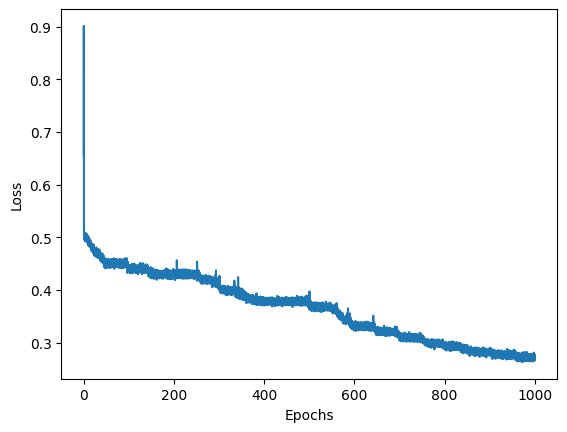

In [23]:
plt.plot(np.linspace(0, 1000, len(losses)), losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")

### Generate Samples

In [24]:
num_samples = 10

# Starting from random noise
x = np.random.rand(num_samples, 44)


for i in range(n_steps -1, 0,-1):
    eta_theta = ddpm_mlp.forward(x, np.array([i]))
    alpha_t = ddpm_params.alphas[i]
    alpha_t_bar = ddpm_params.alpha_bars[i]
    x = (1 / np.sqrt(alpha_t)) * (x - eta_theta*(1 - alpha_t) / np.sqrt((1 - alpha_t_bar)))

X_gen = data_norm.scale_X(x)
Xo = data_norm.scale_X(X)    

In [25]:
'''
=======================

EVAL SAMPLES

========================
'''
tens = np.zeros((len(X_gen),1))+10

x_samples = np.concatenate((tens,X_gen[:,-44:]),axis=-1)

# Clean Up the Vectors
idx_BBFactors = [33,34,35,36,37]
idx_BB = 31

idx_SBFactors = [38,39,40,41,42,43,44]
idx_SB = 32

for i in range(0,len(x_samples)):
    
    x_samples[i,idx_BB] = (x_samples[i,idx_BB] + 0.5) // 1 #int rounds to 1 or 0
    x_samples[i,idx_SB] = (x_samples[i,idx_SB] + 0.5) // 1 #int rounds to 1 or 0
    
    
    x_samples[i,idx_BBFactors] = x_samples[i,idx_BB] * x_samples[i,idx_BBFactors] 
    x_samples[i,idx_SBFactors] = x_samples[i,idx_SB] * x_samples[i,idx_SBFactors]



#Check the constraint violations for the sampled designs
constraints = []
sum_violation = []
cons = []

for i in range(0,len(x_samples)):
    hull = HP(x_samples[i])
    constraints.append(hull.input_Constraints())
    cons.append(constraints[i] > 0)
    sum_violation.append(sum(cons[i]))
    

'''
Now let's figure out which boats do not have any constraint violations and 
learn about them


'''
idx_ZeroCV = [] #going to be a list of boats without violations


max_CV = max(sum_violation) 

count_CV = np.zeros((max_CV+1,))

idx_CV = np.zeros((len(cons[0]),))

Avg_CV = np.mean(sum_violation)

for i in range(0,len(sum_violation)):
    count_CV[sum_violation[i]] +=1
    if sum_violation[i] == 0:
        idx_ZeroCV.append(i)

cons = np.array(cons)
for i in range(0,len(cons[0])):
    idx_CV[i] = sum(cons[:,i])



print(str(int(count_CV[0])) + '/' + str(num_samples))

0/10


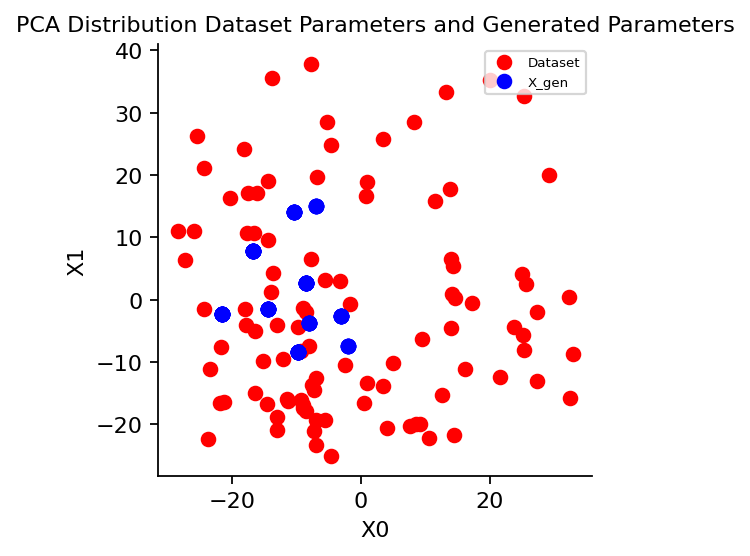

In [26]:

'''
NOW LETS DO A PCA
'''

pca = PCA(n_components = 2)

pca.fit(Xo)

A = np.random.randint(0,len(Xo),100)
B = np.random.randint(0,len(X_gen),100)

components_dataset = pca.transform(Xo[A])

components_gen = pca.transform(X_gen[B])

# Lets Plot PCA

title = 'PCA Distribution Dataset Parameters and Generated Parameters'

fig, axs = plt.subplots(1, 1, figsize=(3.5,3.5), dpi=160)

#plt.xlim(0,2000)

axs.spines["right"].set_visible(False)

axs.spines["top"].set_visible(False)

plt.rcParams['font.size'] = '10'       

axs.set_title(title, fontsize=10)

plt.xlabel('X0', fontsize = 10)

plt.ylabel('X1', fontsize = 10)

axs.plot(components_dataset[:,0], components_dataset[:,1], 'o', color = 'red', label = 'Dataset')

axs.plot(components_gen[:,0], components_gen[:,1], 'o', color = 'blue', label = 'X_gen')

      

plt.legend(fontsize = 6, loc = 'upper right')

plt.show()

## ResNet DDPM

In [27]:
class Denoise_ResNet_Model(eqx.Module):
    fc: list
    xdim: int
    ydim: int
    cdim: int
    tdim: int
    net: list
    X_embed: eqx.Module
    finalLayer: eqx.Module
    time_embed: eqx.Module

    def __init__(self, DDPM_Dict):
        # nn.Module.__init__(self)
        
        self.xdim = DDPM_Dict['xdim']
        self.ydim = DDPM_Dict['ydim']
        self.tdim  = DDPM_Dict['tdim']
        self.cdim = DDPM_Dict['cdim']
        self.net = DDPM_Dict['net']
        
        self.fc = [] #nn.ModuleList()

        key = jax.random.PRNGKey(0)
        
        self.fc.append(self.LinLayer(self.tdim,self.net[0])) # 128 -> 1024
        
        for i in range(1, len(self.net)):
            self.fc.append(self.LinLayer(self.net[i-1],self.net[i])) # 1024 -> 1024
            
        self.fc.append(self.LinLayer(self.net[-1], self.tdim)) # 1024 -> 128
        
        
        self.finalLayer = eqx.nn.Sequential([eqx.nn.Linear(self.tdim, self.xdim, key=key)]) # 128 -> 44
        
    
        self.X_embed = eqx.nn.Linear(self.xdim, self.tdim, key=key)
        
        '''
        self.Y_embed = nn.Sequential(
            nn.Linear(self.ydim, self.tdim),
            nn.SiLU(),
            nn.Linear(self.tdim, self.tdim))
        
        
        self.Con_embed = nn.Sequential(
                    nn.Linear(self.cdim, self.tdim),
                    nn.SiLU(),
                    nn.Linear(self.tdim, self.tdim))
        
        '''
        
        self.time_embed = eqx.nn.Sequential([
            eqx.nn.Linear(self.tdim, self.tdim, key=key),
            eqx.nn.Lambda(jax.nn.silu),
            eqx.nn.Linear(self.tdim, self.tdim, key=key)])
       # 128 -> 128
        
    def LinLayer(self, dimi, dimo):
        key = jax.random.PRNGKey(0)
        return eqx.nn.Sequential([eqx.nn.Linear(dimi,dimo, key=key),
                             eqx.nn.Lambda(jax.nn.silu),
                            #  eqx.nn.BatchNorm(dimo,axis_name=dimi), # Fix batchnorm
                             eqx.nn.Dropout(p=0.1, inference=True)])
        

    @partial(jax.vmap, in_axes=(None, 0))
    def make_time_embed(self, x):
        return self.time_embed(x)
    
    @partial(jax.vmap, in_axes=(None, 0, 0))
    def __call__(self, x, timesteps):
        
                
        x = self.X_embed(x) + self.make_time_embed(timestep_embedding(timesteps, self.tdim).reshape(1, self.tdim)).reshape(self.tdim,)
        res_x = x

        for i in range(0,len(self.fc)):
        # for i in range(0,1):
            x = self.fc[i](x)
        
        # print(x.shape)
    
        x = jnp.add(x,res_x)
        
        x = self.finalLayer(x)
        
        return x
    

    @partial(jax.vmap, in_axes=(None, 0, None))
    def forward(self, x, timesteps):
        
                
        x = self.X_embed(x) + self.make_time_embed(timestep_embedding(timesteps, self.tdim).reshape(1, self.tdim)).reshape(self.tdim,)
        res_x = x

        for i in range(0,len(self.fc)):
        # for i in range(0,1):
            x = self.fc[i](x)
        
        # print(x.shape)
    
        x = jnp.add(x,res_x)
        
        x = self.finalLayer(x)
        
        return x

In [28]:
ddpm_resnet = Denoise_ResNet_Model(DDPM_Dict)

x = np.random.rand(120, 44)
# x = np.random.rand(44)
n = 120
n_steps = 200
t = np.random.choice(n_steps, (n,1))

print(t.shape)

# ddpm_resnet.time_embed(t).shape

# ddpm_resnet.make_time_embed(t).shape

ddpm_resnet(x, t)

(120, 1)


Array([[ 0.05560558, -0.15498024,  0.00952887, ..., -0.2994128 ,
        -0.10507368, -0.33041176],
       [ 0.04064599, -0.12164424, -0.11295878, ..., -0.07870425,
         0.02178966, -0.3359106 ],
       [-0.21859586, -0.09627332, -0.07549338, ..., -0.0874709 ,
        -0.12565663, -0.34298328],
       ...,
       [ 0.00722723,  0.12167475, -0.19746134, ..., -0.13529792,
        -0.02523326, -0.06457511],
       [ 0.18032324, -0.09110239, -0.2342596 , ..., -0.13776094,
         0.05160934, -0.53116995],
       [-0.01900683, -0.02567339, -0.21201071, ..., -0.07508508,
        -0.10058805, -0.2670142 ]], dtype=float32)

In [29]:
ddpm_resnet_mlp = Denoise_ResNet_Model(DDPM_Dict)

### Training

In [30]:
n = 100

x = np.random.rand(n, 44)

n_steps = 200
t = np.random.choice(n_steps, (n,1))
eta = np.random.randn(n, 44)

noisy_imgs = ddpm_params(x, t, eta)
print('noisy_imgs', noisy_imgs.shape)

print('t', t.shape)

eta_theta = ddpm_resnet_mlp(noisy_imgs, t)
print('eta_theta', eta_theta.shape)
# loss(ddpm_resnet_mlp, ddpm_params, x, t, eta)

noisy_imgs (100, 44)
t (100, 1)
eta_theta (100, 44)


In [31]:
ddpm_params = forward_net(n_steps=200, min_beta=10 ** -4, max_beta=0.02, datalength=len(X), batch_size = 1024)
ddpm_resnet_mlp = Denoise_ResNet_Model(DDPM_Dict)

In [32]:
ddpm_resnet_mlp, losses = training_loop_ddpm(ddpm_params, ddpm_resnet_mlp, 3, optax.adam(0.01))

1000
Epoch:  0
7.233169
Epoch:  1
0.5297201
Epoch:  2
0.4510485
Epoch:  3
0.42308372
Epoch:  4
0.4030329
Epoch:  5
0.38633373
Epoch:  6
0.37201566
Epoch:  7
0.3615924
Epoch:  8
0.34954166
Epoch:  9
0.3422521
Epoch:  10
0.33395615
Epoch:  11
0.32802147
Epoch:  12
0.32165465
Epoch:  13
0.3184461
Epoch:  14
0.31211376
Epoch:  15
0.30908868
Epoch:  16
0.3087376
Epoch:  17
0.30271244
Epoch:  18
0.3019269
Epoch:  19
0.29849818
Epoch:  20
0.29561257
Epoch:  21
0.295039
Epoch:  22
0.29382434
Epoch:  23
0.29174167
Epoch:  24
0.2909
Epoch:  25
0.28809592
Epoch:  26
0.2875437
Epoch:  27
0.28576055
Epoch:  28
0.285401
Epoch:  29
0.28441674
Epoch:  30
0.28339177
Epoch:  31
0.28339887
Epoch:  32
0.2826769
Epoch:  33
0.28324324
Epoch:  34
0.28129575
Epoch:  35
0.2808511
Epoch:  36
0.27995634
Epoch:  37
0.28106892
Epoch:  38
0.28021497
Epoch:  39
0.28063112
Epoch:  40
0.28051236
Epoch:  41
0.28075
Epoch:  42
0.28092036
Epoch:  43
0.2811005
Epoch:  44
0.28501165
Epoch:  45
0.28140953
Epoch:  46
0.28104

(0.0, 0.5)

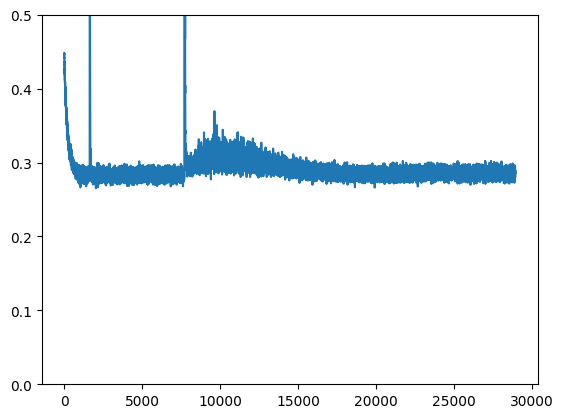

In [33]:
plt.plot(losses[80:])
plt.ylim(0, 0.5)

### Generate Samples

In [34]:
num_samples = 10

# Starting from random noise
x = np.random.rand(num_samples, 44)


for i in range(n_steps -1, 0,-1):
    eta_theta = ddpm_resnet_mlp.forward(x, np.array([i]))
    alpha_t = ddpm_params.alphas[i]
    alpha_t_bar = ddpm_params.alpha_bars[i]
    x = (1 / np.sqrt(alpha_t)) * (x - eta_theta*(1 - alpha_t) / np.sqrt((1 - alpha_t_bar)))

X_gen = data_norm.scale_X(x)
Xo = data_norm.scale_X(X)    

In [35]:
'''
=======================

EVAL SAMPLES

========================
'''
tens = np.zeros((len(X_gen),1))+10

x_samples = np.concatenate((tens,X_gen[:,-44:]),axis=-1)

# Clean Up the Vectors
idx_BBFactors = [33,34,35,36,37]
idx_BB = 31

idx_SBFactors = [38,39,40,41,42,43,44]
idx_SB = 32

for i in range(0,len(x_samples)):
    
    x_samples[i,idx_BB] = (x_samples[i,idx_BB] + 0.5) // 1 #int rounds to 1 or 0
    x_samples[i,idx_SB] = (x_samples[i,idx_SB] + 0.5) // 1 #int rounds to 1 or 0
    
    
    x_samples[i,idx_BBFactors] = x_samples[i,idx_BB] * x_samples[i,idx_BBFactors] 
    x_samples[i,idx_SBFactors] = x_samples[i,idx_SB] * x_samples[i,idx_SBFactors]



#Check the constraint violations for the sampled designs
constraints = []
sum_violation = []
cons = []

for i in range(0,len(x_samples)):
    hull = HP(x_samples[i])
    constraints.append(hull.input_Constraints())
    cons.append(constraints[i] > 0)
    sum_violation.append(sum(cons[i]))
    

'''
Now let's figure out which boats do not have any constraint violations and 
learn about them


'''
idx_ZeroCV = [] #going to be a list of boats without violations


max_CV = max(sum_violation) 

count_CV = np.zeros((max_CV+1,))

idx_CV = np.zeros((len(cons[0]),))

Avg_CV = np.mean(sum_violation)

for i in range(0,len(sum_violation)):
    count_CV[sum_violation[i]] +=1
    if sum_violation[i] == 0:
        idx_ZeroCV.append(i)

cons = np.array(cons)
for i in range(0,len(cons[0])):
    idx_CV[i] = sum(cons[:,i])



print(str(int(count_CV[0])) + '/' + str(num_samples))

8/10


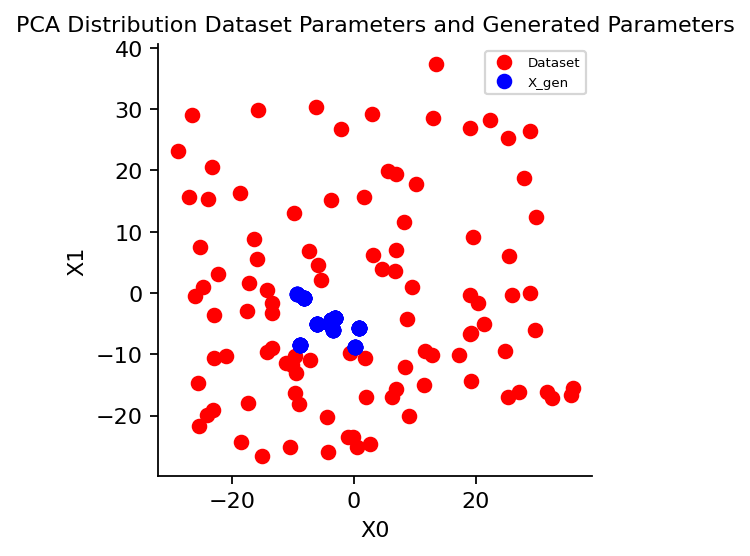

In [36]:

'''
NOW LETS DO A PCA
'''

pca = PCA(n_components = 2)

pca.fit(Xo)

A = np.random.randint(0,len(Xo),100)
B = np.random.randint(0,len(X_gen),100)

components_dataset = pca.transform(Xo[A])

components_gen = pca.transform(X_gen[B])

# Lets Plot PCA

title = 'PCA Distribution Dataset Parameters and Generated Parameters'

fig, axs = plt.subplots(1, 1, figsize=(3.5,3.5), dpi=160)

#plt.xlim(0,2000)

axs.spines["right"].set_visible(False)

axs.spines["top"].set_visible(False)

plt.rcParams['font.size'] = '10'       

axs.set_title(title, fontsize=10)

plt.xlabel('X0', fontsize = 10)

plt.ylabel('X1', fontsize = 10)

axs.plot(components_dataset[:,0], components_dataset[:,1], 'o', color = 'red', label = 'Dataset')

axs.plot(components_gen[:,0], components_gen[:,1], 'o', color = 'blue', label = 'X_gen')

      

plt.legend(fontsize = 6, loc = 'upper right')

plt.show()

## Classifier - Feasiblity

In [37]:
class Classifier_Model(eqx.Module):
    xdim: int
    cdim: int
    tdim: int
    net: list
    fc: list
    time_embed: eqx.Module
    X_embed: eqx.Module

    def __init__(self, Dict):
        # nn.Module.__init__(self)
        super(Classifier_Model, self).__init__()
        self.xdim = Dict['xdim']
        self.tdim = Dict['tdim']
        self.cdim = Dict['cdim']

        self.net = Dict['net']
        
        self.fc = [] #nn.ModuleList()

        key = jax.random.PRNGKey(0)        
        
        self.time_embed = eqx.nn.Sequential([
            eqx.nn.Linear(self.tdim, self.tdim, key=key),
            eqx.nn.Lambda(jax.nn.silu),
            eqx.nn.Linear(self.tdim, self.tdim, key=key)])
        
        self.X_embed = eqx.nn.Linear(self.xdim, self.tdim, key=key)
        
        self.fc.append(self.LinLayer(self.tdim,self.net[0]))
        '''
        self.fc.append(self.LinLayer(self.xdim,self.net[0]))
        '''
        
        for i in range(1, len(self.net)):
            self.fc.append(self.LinLayer(self.net[i-1],self.net[i]))
            
        
        self.fc.append(eqx.nn.Sequential([eqx.nn.Linear(self.net[-1], self.cdim, key=key), eqx.nn.Lambda(jax.nn.sigmoid)]))

    def LinLayer(self, dimi, dimo):
        key = jax.random.PRNGKey(0)
        return eqx.nn.Sequential([eqx.nn.Linear(dimi,dimo, key=key),
                             eqx.nn.Lambda(jax.nn.silu),
                             #nn.BatchNorm1d(dimo),
                             eqx.nn.Dropout(p=0.1, inference=True)])
        
    @partial(jax.vmap, in_axes=(None, 0))
    def __call__(self, x):
        
        x = self.X_embed(x)
        
        for i in range(0,len(self.fc)):
            x = self.fc[i](x)  
        return x

In [38]:
Xc = jnp.concatenate((X,X_neg))
C = jnp.concatenate((Cons,Cons_neg))

In [39]:
Classify_Dict = {
        'xdim' : len(Xc[0]),
        'cdim': len(Cons[0]),
        'tdim': 128,
        'net': [64,64,64],
        'Training_Epochs': 150000,
        'device_name': 'cuda:0'}

Classif = Classifier_Model(Classify_Dict)

In [40]:
x = np.random.randn(120, 44)
Classif(x)

Array([[0.4835704 ],
       [0.48411995],
       [0.48256317],
       [0.4829787 ],
       [0.4820229 ],
       [0.48352766],
       [0.48107696],
       [0.4820651 ],
       [0.48417595],
       [0.48066986],
       [0.48278224],
       [0.48772067],
       [0.4823098 ],
       [0.4841188 ],
       [0.4794651 ],
       [0.48381114],
       [0.48314327],
       [0.48303178],
       [0.48652297],
       [0.48313308],
       [0.4842454 ],
       [0.47953042],
       [0.48254514],
       [0.48118833],
       [0.48642373],
       [0.48373392],
       [0.48170796],
       [0.4849946 ],
       [0.48248535],
       [0.4842688 ],
       [0.482928  ],
       [0.4839152 ],
       [0.4827219 ],
       [0.48167518],
       [0.4836603 ],
       [0.48495534],
       [0.48345062],
       [0.48333904],
       [0.47886044],
       [0.48123914],
       [0.48642358],
       [0.48337358],
       [0.48359236],
       [0.48379225],
       [0.48401806],
       [0.48064607],
       [0.48034328],
       [0.485

### Training Loop

In [41]:
def loss(model, x, c):
    y = model(x)
    # Optimizing the BCE loss
    return optax.sigmoid_binary_cross_entropy(y, c).mean()

loss = eqx.filter_jit(loss) 

In [42]:
def training_loop_classifier(model, n_epochs = 1, optim=optax.adam(0.01)):    
    optim=optax.adam(0.01)
    datalength = Xc.shape[0]
    batch_size = 1024
    print('Classifier Model Training...')
    num_batches = datalength // batch_size
    batches_per_epoch = 100
    batches_per_epoch = min(num_batches,batches_per_epoch)
    n_epochs = 100 # Classify_Dict['Training_Epochs']

    losses = []
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def opt_step(opt_state, model, x, c):
        value, grads = eqx.filter_value_and_grad(loss)(model, x, c)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, value

    for i in range(n_epochs):
        print('Epoch:', i)
        epoch_loss = 0.0
        for j in range(0, batches_per_epoch):
            
            i = np.random.randint(0, len(Xc), batch_size)
            x = Xc[i]
            c = C[i]
            
            model, opt_state, value = opt_step(opt_state, model, x, c)

            losses.append(value)
            epoch_loss += value * batch_size / len(Xc)
        
        print('Loss:', epoch_loss)
    return model, losses

In [43]:
Classif, losses = training_loop_classifier(Classif, 3, optax.adam(0.01))

Classifier Model Training...
Epoch: 0
Loss: 0.59880406
Epoch: 1
Loss: 0.58180493
Epoch: 2
Loss: 0.57909673
Epoch: 3
Loss: 0.5806605
Epoch: 4
Loss: 0.5873616
Epoch: 5
Loss: 0.586479
Epoch: 6
Loss: 0.5850377
Epoch: 7
Loss: 0.5851038
Epoch: 8
Loss: 0.5905161
Epoch: 9
Loss: 0.5883365
Epoch: 10
Loss: 0.5988101
Epoch: 11
Loss: 0.60159314
Epoch: 12
Loss: 0.6329618
Epoch: 13
Loss: 0.639106
Epoch: 14
Loss: 0.63350666
Epoch: 15
Loss: 0.6368223
Epoch: 16
Loss: 0.62995166
Epoch: 17
Loss: 0.62198097
Epoch: 18
Loss: 0.61476445
Epoch: 19
Loss: 0.6217818
Epoch: 20
Loss: 0.8060436
Epoch: 21
Loss: 0.8420492
Epoch: 22
Loss: 0.8374798
Epoch: 23
Loss: 0.6637926
Epoch: 24
Loss: 0.6652654
Epoch: 25
Loss: 0.68139166
Epoch: 26
Loss: 0.68139166
Epoch: 27
Loss: 0.68139166
Epoch: 28
Loss: 0.68139166
Epoch: 29
Loss: 0.68139166
Epoch: 30
Loss: 0.68139166
Epoch: 31
Loss: 0.68139166
Epoch: 32
Loss: 0.68139166
Epoch: 33
Loss: 0.68139166
Epoch: 34
Loss: 0.68139166
Epoch: 35
Loss: 0.68139166
Epoch: 36
Loss: 0.68139166
E

## Classifier Guided Sample Generation

In [109]:
Classif = Classif
gamma = 0.5


In [110]:
def class_grad():
    error = lambda a, model, y : optax.sigmoid_binary_cross_entropy(model(a), y).mean()
    grad = jax.grad(error)
    return grad

feas_grad = class_grad()

In [1]:
# t = np.ones((num_samples,1)) +0.0
# x = np.random.randn(num_samples, 44)
# feas_grad(x, Classif, t)

In [112]:
def err(x, model, t): 
    # y = np.zeros((num_samples,1)) +0.0
    e = (t - model(x))**2
    return e.mean()

In [2]:
# t = np.zeros((num_samples,1)) +0.0
# x = np.random.randn(num_samples, 44)
# # print(t)
# # print(x)

# # error = lambda a, model, y : optax.sigmoid_binary_cross_entropy(model(a), y).mean()
# grad = jax.grad(err, argnums = 0)
# grad(x, Classif, t)

In [54]:
num_samples = 10

# Starting from random noise
x = np.random.rand(num_samples, 44)
t = np.zeros((num_samples,1)) +0.0

for i in range(n_steps -1, 0,-1):
    eta_theta = ddpm_resnet_mlp.forward(x, np.array([i]))
    alpha_t = ddpm_params.alphas[i]
    alpha_t_bar = ddpm_params.alpha_bars[i]
    mean_x = (1 / np.sqrt(alpha_t)) * (x - eta_theta*(1 - alpha_t) / np.sqrt((1 - alpha_t_bar)))
    x = mean_x + feas_grad(x, Classif, t)*gamma

X_gen = data_norm.scale_X(x)
Xo = data_norm.scale_X(X)    

## Regression ResNet - Performance

In [55]:
class Regression_ResNet_Model(eqx.Module):
    xdim: int
    ydim: int
    tdim: int
    net: list
    fc: list
    finalLayer: eqx.Module
    X_embed: eqx.Module
    
    def __init__(self, Reg_Dict):
        # nn.Module.__init__(self)
        super(Regression_ResNet_Model, self).__init__()
        self.xdim = Reg_Dict['xdim']
        self.ydim = Reg_Dict['ydim']
        self.tdim = Reg_Dict['tdim']
        self.net = Reg_Dict['net']
        
        key = jax.random.PRNGKey(0)
        
        self.fc = [] #nn.ModuleList()
        
        self.fc.append(self.LinLayer(self.tdim,self.net[0]))
        
        for i in range(1, len(self.net)):
            self.fc.append(self.LinLayer(self.net[i-1],self.net[i]))
            
        self.fc.append(self.LinLayer(self.net[-1], self.tdim))
        
        
        self.finalLayer = eqx.nn.Sequential([eqx.nn.Linear(self.tdim, self.ydim, key=key)])
        
    
        self.X_embed = eqx.nn.Linear(self.xdim, self.tdim, key=key)
       
        
    def LinLayer(self, dimi, dimo):
        key = jax.random.PRNGKey(0)
        return eqx.nn.Sequential([eqx.nn.Linear(dimi,dimo, key=key),
                             eqx.nn.Lambda(jax.nn.silu),
                             eqx.nn.LayerNorm(dimo),
                             eqx.nn.Dropout(p=0.2, inference=True)])
        
    @partial(jax.vmap, in_axes=(None, 0))
    def __call__(self, x):

                
        x = self.X_embed(x) 
        res_x = x
        
        for i in range(0,len(self.fc)):
            x = self.fc[i](x)
    
        x = jnp.add(x,res_x)
        
        x = self.finalLayer(x)
        
        return x

In [56]:
Reg_Dict = {
        'xdim' : len(X[0]),                     # Dimension of parametric design vector
        'ydim': 1,                              # trains regression model for each objective
        'tdim': 256,                            # dimension of latent variable
        'net': [256,256],                       # network architecture        
        'Training_Epochs': 10000,               # number of training epochs
        'num_regressors': 7,                    # number of regressors to train
        'Model_Labels': ['Regressor_Cw',        # labels for regressors
                        'Regressor_SA_050',
                        'Regressor_SA_100',
                        'Regressor_Vol_050',
                        'Regressor_Vol_100',
                        'Regressor_MaxBox_Volume',
                        'Regressor_GaussianCurvature'],
        'lr' : 0.001,                          # learning rate
        'weight_decay': 0.0,                   # weight decay
        'device_name': 'cuda:0'}               # gpu device name


R = Regression_ResNet_Model(Reg_Dict)

In [57]:
x = np.random.randn(120, 44)
R(x).shape

(120, 1)

In [58]:
n_reg = 7

regressors = [Regression_ResNet_Model(Reg_Dict) for i in range(0,n_reg)]


In [59]:
regressors[2](x)

Array([[ 0.656985  ],
       [ 0.07311164],
       [-0.13783093],
       [ 0.31618792],
       [ 0.25169486],
       [-1.741028  ],
       [ 0.5605563 ],
       [ 0.60591656],
       [-0.04810555],
       [ 0.3477887 ],
       [-0.8252254 ],
       [-0.15333493],
       [-0.38379478],
       [ 0.08934431],
       [-0.5210724 ],
       [ 0.95851594],
       [ 0.79275686],
       [ 0.14461334],
       [-0.40002877],
       [-0.14162004],
       [-0.39150673],
       [-1.1662914 ],
       [ 0.29342753],
       [-0.51922   ],
       [ 1.0080804 ],
       [-0.5278278 ],
       [-0.9772792 ],
       [ 0.22414984],
       [-0.19080614],
       [-0.70093685],
       [-1.9205587 ],
       [-0.04345916],
       [ 0.67904   ],
       [-0.7398093 ],
       [ 1.3603133 ],
       [-0.7075159 ],
       [ 0.96598166],
       [ 1.1736931 ],
       [-0.6066353 ],
       [-0.7079459 ],
       [ 0.02304684],
       [-0.34973574],
       [ 0.51764244],
       [-1.8194605 ],
       [ 0.5809954 ],
       [-0

### Training Loop

In [60]:
Y.shape

(30000, 7)

In [61]:
def loss(model, x, y):
    y_pred = model(x)
    # Optimizing the BCE loss
    return optax.l2_loss(y, y_pred).mean()

loss = eqx.filter_jit(loss) 

In [62]:
def training_loop_reg(model, n_epochs = 1, optim=optax.adam(0.01), reg_index = 0):    
    optim=optax.adam(0.01)
    datalength = X.shape[0]
    batch_size = 1024
    print('Regressor Model Training for Regressor:', Reg_Dict['Model_Labels'][reg_index])
    num_batches = datalength // batch_size
    batches_per_epoch = 100
    batches_per_epoch = min(num_batches,batches_per_epoch)
    n_epochs = 100 #

    losses = []
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def opt_step(opt_state, model, x, y):
        value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, value

    for i in range(n_epochs):
        epoch_loss = 0.0
        for j in range(0, batches_per_epoch):
            
            i = np.random.randint(0, len(X), batch_size)
            x = X[i]
            y = Y[i,reg_index:reg_index+1]
            
            model, opt_state, value = opt_step(opt_state, model, x, y)

            losses.append(value)
            epoch_loss += value * batch_size / len(X)
        
        print('Loss:', epoch_loss)
    return model, losses

In [63]:
for i in range(n_reg):
    regressors[i], losses = training_loop_reg(regressors[i], 1, optax.adam(0.01), i)

Regressor Model Training for Regressor: Regressor_Cw
Loss: 633.69696
Loss: 123.32813
Loss: 63.003506
Loss: 64.726456
Loss: 61.384403
Loss: 61.439655
Loss: 61.809673
Loss: 62.753395
Loss: 62.363384
Loss: 61.02603
Loss: 59.98646
Loss: 57.585617
Loss: 52.01222
Loss: 49.280922
Loss: 48.46475
Loss: 44.1193
Loss: 43.58647
Loss: 37.907864
Loss: 30.037287
Loss: 28.89248
Loss: 26.484879
Loss: 25.226435
Loss: 23.45851
Loss: 22.034918
Loss: 22.40349
Loss: 22.239859
Loss: 19.593355
Loss: 19.154722
Loss: 18.090002
Loss: 17.11444
Loss: 15.2845745
Loss: 13.355727
Loss: 12.468722
Loss: 10.5695095
Loss: 9.99932
Loss: 10.49197
Loss: 8.898582
Loss: 9.437884
Loss: 8.387341
Loss: 8.822502
Loss: 8.222633
Loss: 8.094711
Loss: 8.436562
Loss: 8.578526
Loss: 7.729583
Loss: 7.411438
Loss: 6.634535
Loss: 6.795783
Loss: 7.374298
Loss: 6.903778
Loss: 6.437803
Loss: 6.7214165
Loss: 5.990625
Loss: 6.288177
Loss: 6.4982934
Loss: 5.5167446
Loss: 5.9334245
Loss: 6.035741
Loss: 5.528243
Loss: 4.9649734
Loss: 5.1627383
Lo

In [64]:
Rsq = np.zeros((n_reg,))
for i in range(n_reg):
    y_pred = regressors[i](X)
    Rsq[i] = r2_score(Y[:,i], y_pred)

In [65]:
Rsq

array([0.98061834, 0.95752048, 0.94366298, 0.96980319, 0.94385391,
       0.37329251, 0.49647448])

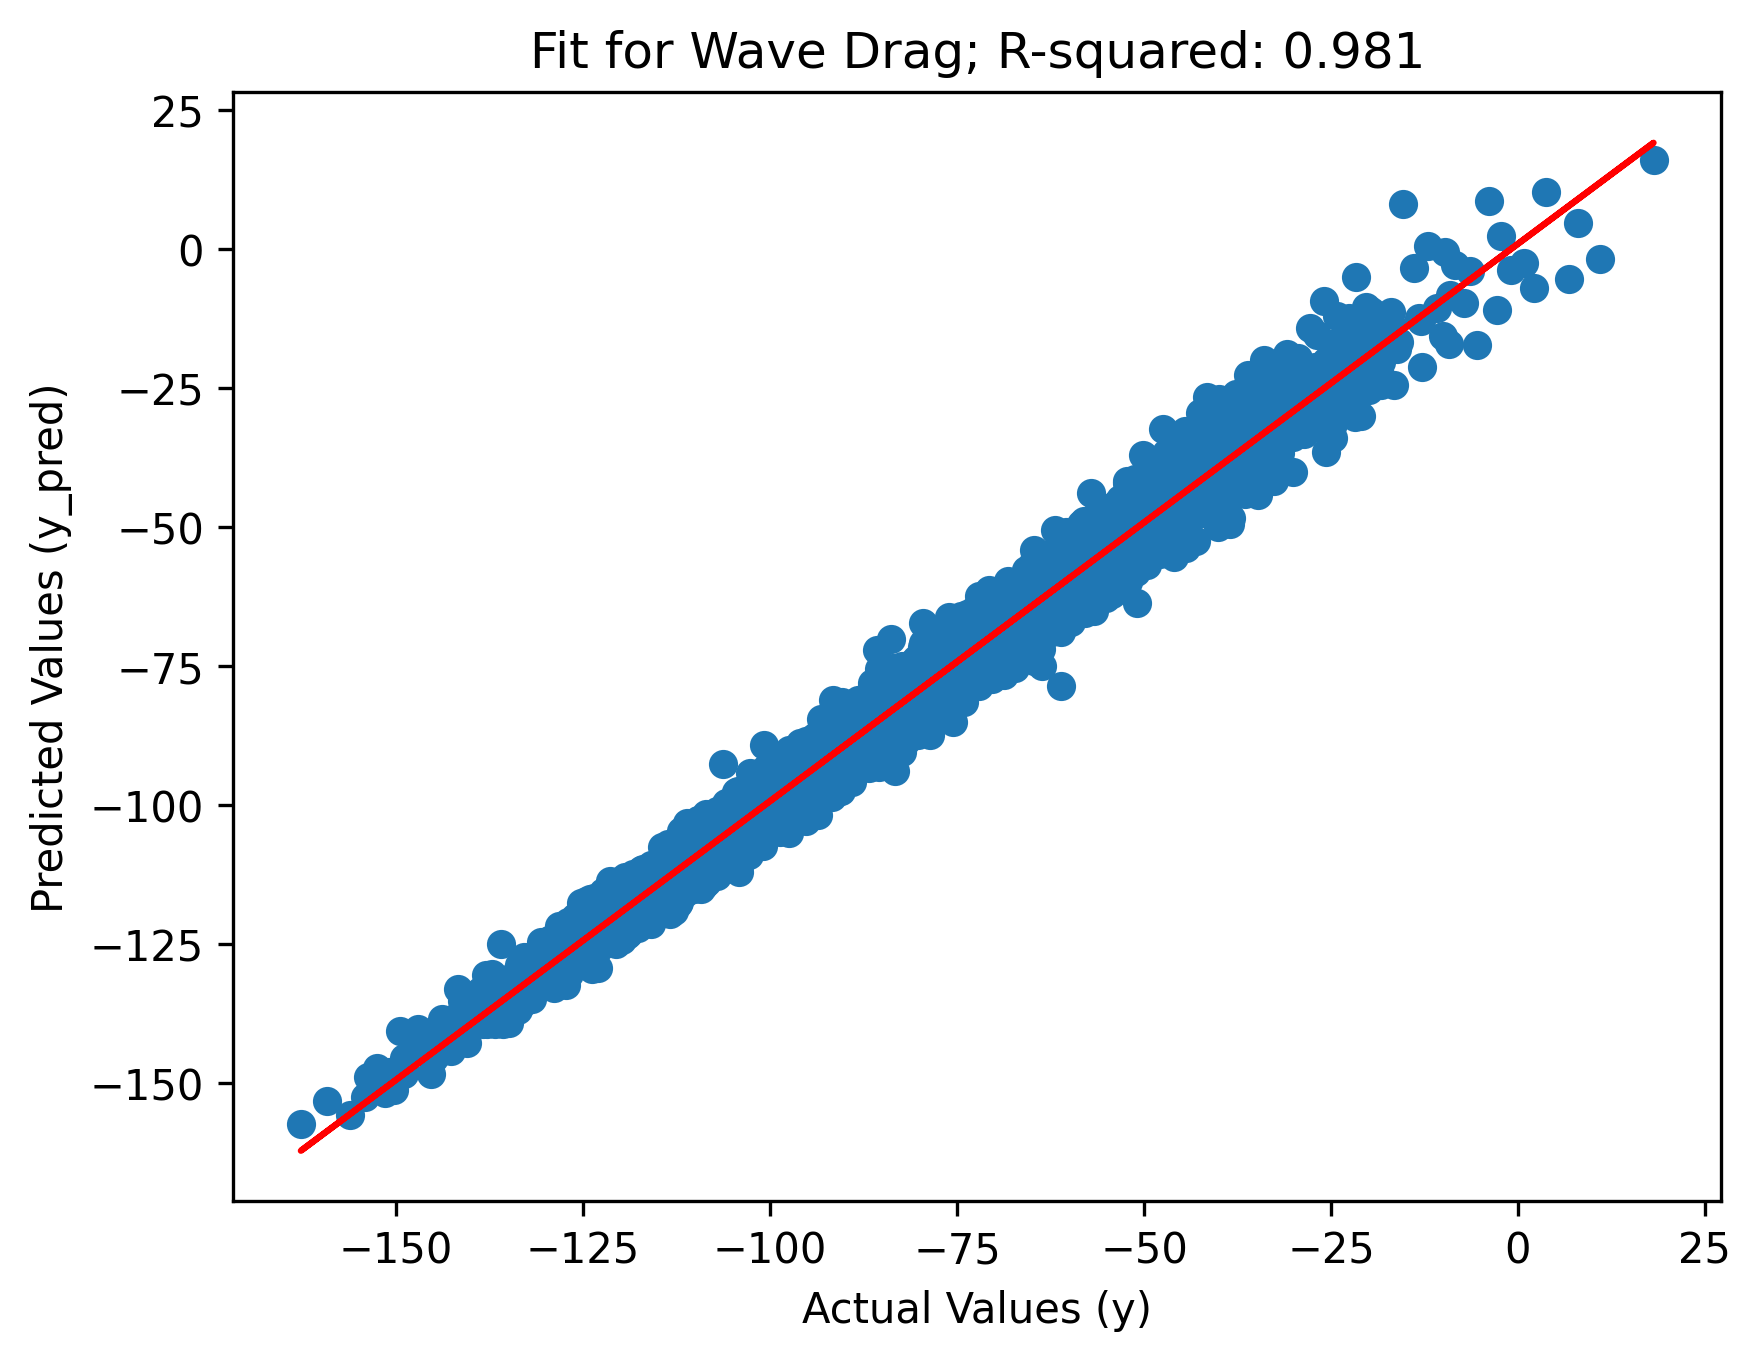

In [73]:
## Y vs Y_pred Plot

y_pred = regressors[0](X)
y = Y[:,0]
r_squared = r2_score(y, y_pred)

# Create the plot
fig, ax = plt.subplots()

# Scatter plot
ax.scatter(y, y_pred)

# Linear regression line
slope, intercept = np.polyfit(y, y_pred, 1)
ax.plot(y, slope * y + intercept, color='r')

# Label and title the plot
ax.set_xlabel('Actual Values (y)')
ax.set_ylabel('Predicted Values (y_pred)')
plt.title(f"Fit for Wave Drag; R-squared: {r_squared:.3f}")
plt.rcParams['figure.dpi'] = 300
# Show the plot
plt.show()

## Performance and feasiblity constraint guided sample-generation

In [113]:
error = lambda a, model : model(a.reshape(1,-1))[0][0]
pgrad = jax.grad(error)


p_grad = vmap(pgrad, (0, None), 0) 

In [116]:
x = np.random.randn(num_samples, 44)
model = regressors[0]

p_grad(x, model)

Array([[  0.9518161 ,  -1.7808741 ,   0.9727415 ,   9.989376  ,
          0.43864298,  -0.36488563,  -0.6577771 ,  -3.5288558 ,
         -1.8181446 ,   4.07782   ,  -0.8524419 ,  -0.5038108 ,
          0.5660647 ,  -0.9287925 ,  -0.85152894,  -0.60429555,
         10.79479   ,  18.442688  ,  12.419253  ,  -0.01295589,
          0.18605694,   0.22522132,  -0.85812664,   0.34224263,
         -1.711729  ,  -0.9666379 ,  -0.7528656 ,   0.5829291 ,
         -0.16441706,   0.5363208 ,  -2.8727312 ,  -3.2130756 ,
          0.5914429 ,   1.2055    ,   0.96529424,  -0.254345  ,
          1.2512097 ,   0.87884444,   0.5888491 ,   0.5773903 ,
          0.9483654 ,   1.133631  ,  -0.52117914,   0.44110695],
       [ -6.8839207 ,   3.5180612 ,   3.1300743 ,  16.704273  ,
          0.07331586,  -1.4913876 ,   3.8365743 ,   0.9225007 ,
        -12.140768  ,  -8.437736  ,  -4.222563  ,  -3.1032264 ,
          1.1014875 ,   2.8527348 ,   8.362166  ,   2.2071047 ,
        -10.990143  , -24.425821  , -12

In [115]:
num_samples = 10

# Starting from random noise
x = np.random.rand(num_samples, 44)
t = np.zeros((num_samples,1)) +0.0


for i in range(n_steps -1, 0,-1):
    eta_theta = ddpm_resnet_mlp.forward(x, np.array([i]))
    alpha_t = ddpm_params.alphas[i]
    alpha_t_bar = ddpm_params.alpha_bars[i]
    mean_x = (1 / np.sqrt(alpha_t)) * (x - eta_theta*(1 - alpha_t) / np.sqrt((1 - alpha_t_bar)))
    x = mean_x + feas_grad(x, Classif, t)*gamma - p_grad(x, regressors[0])

X_gen = data_norm.scale_X(x)
Xo = data_norm.scale_X(X)    